In [6]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
import stingray.gti as sting_gti
import stingray.pulse.pulsar as plsr
from stingray import stats
from astropy.timeseries import LombScargle




sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *

def minimize_remainder(arr, min_div, max_div):
    divisors = np.linspace(min_div, max_div, num=100)
    remainders = []
    for div in divisors:
        remainders.append(np.sum(np.mod(arr, div)))
        
    return divisors[np.argmin(remainders)]

def power_law(f, B, gamma):
    return B*np.power(f,gamma)

def Lorentzian(f, peakf, Q, A):
    # gamma = HWHM
    # peakf = centroid frequency
    gamma = peakf/(2.0 * Q)
    return (A * np.square(gamma)/(np.pi*gamma*(np.square(f-peakf) + np.square(gamma))))

def Lorentzian_C(f, peakf, Q, A, C):
    return Lorentzian(f, peakf, Q, A) + C

def Lorentzian_power(f, peakf, Q, A, B, gamma):
    return Lorentzian(f, peakf, Q, A) + power_law(f, B, gamma)

def N_Lorentzian(f, *args):
    N = int(len(args)/3)
    peak_nu = args[:N]
    Qs = args[N:N+N]
    As = args[N+N:N+N+N]
    model = np.zeros(np.shape(f))
    for i in range(N):
        model = model + Lorentzian(f, peak_nu[i], Qs[i], As[i])
        
    return model

def N_Lorentzian_C(f, *args):
    N = int((len(args)-1)/3)
    peak_nu = args[:N]
    Qs = args[N:N+N]
    As = args[N+N:N+N+N]
    C = args[-1]
    model = C * np.ones(np.shape(f))
    for i in range(N):
        model = model + Lorentzian(f, peak_nu[i], Qs[i], As[i])
        
    return model

def N_Lorentzian_power(f, *args):
    N = int((len(args)-2)/3)
    peak_nu = args[:N]
    Qs = args[N:N+N]
    As = args[N+N:N+N+N]
    B, alpha = args[-2:]
    model = power_law(f, B, alpha)
    for i in range(N):
        model = model + Lorentzian(f, peak_nu[i], Qs[i], As[i])
        
    return model

def QPO_scan(cross_spec, f_min=1e-4, f_max=2000., f_bin=1000, n_lorentz = 1):
    f_mask = (cross_spec.freq > f_min) * (cross_spec.freq < f_max)
    freq_steps = np.logspace(np.log10(cross_spec.freq[f_mask][0]), np.log10(cross_spec.freq[f_mask][-1]), f_bin + 2)
    xdata = cross_spec.freq[f_mask]
    ydata = cross_spec.power[f_mask]
    sigma = cross_spec.power_err[f_mask]
    
    pl_popt, pl_pcov = scipy.optimize.curve_fit(power_law, xdata, ydata, sigma = sigma, p0 = [10., -1.0], \
                                                bounds=np.array([(0.0, np.inf), (-np.inf, 0.0)]).T)
    print(pl_popt)
    chisq0 = np.sum(((ydata - power_law(xdata, *pl_popt)) / sigma) ** 2)
    print(chisq0)
    print(chisq0/(len(ydata)-len(pl_popt)))
    chisq = []
    for i in tqdm(range(len(freq_steps[1:-1]))):
        f = freq_steps[i+1]
        try:
            popt, pcov = scipy.optimize.curve_fit(Lorentzian_power, xdata, ydata, sigma = sigma, p0 = [f, 2.0, 1e-3, pl_popt[0], pl_popt[1]], \
                                                  bounds=np.array([(f - (f-freq_steps[i])/2., f + (freq_steps[i+2] - f)/2.0), (1.0,np.inf), (0.0,np.inf), (0.0, np.inf), (-np.inf, 0.0)]).T)
            chisq.append(np.sum(((ydata - Lorentzian_power(xdata, *popt)) / sigma) ** 2))
        except RuntimeError:
            print("No acceptable fit")
            chisq.append(chisq0)
    dof = len(xdata)-len(popt)
    return freq_steps[1:-1], chisq0, np.array(chisq), dof



def fit_peaks(xdata, ydata, sigma, nu_peak):
    
    popt_arr = []
    pcov_arr = []

    for i, p in enumerate(nu_peak):
        f_bound = None
        if len(nu_peak)==1:
            f_bound = (np.min(xdata), np.max(xdata))
        else:
            if i == 0:
                f_bound = (np.min(xdata), p + (nu_peak[i+1] - p)/2)
            elif i==len(nu_peak)-1:
                f_bound = (p + (nu_peak[i-1] - p)/2, np.max(xdata))
            else:
                f_bound = (p + (nu_peak[i-1] - p)/2, p + (nu_peak[i+1] - p)/2)

        par_bounds = np.array([f_bound, (1.0,np.inf), (0, np.inf), (0, np.inf), (-np.inf, 0.0)]).T
        p0 = [p, 5.0, 0.1, 0.02, -0.5]
        popt, pcov = scipy.optimize.curve_fit(Lorentzian_power, xdata, ydata, sigma = sigma, p0 = p0, bounds = par_bounds)
        popt_arr.append(popt)
        pcov_arr.append(pcov)

    popt_arr = np.array(popt_arr)
    pcov_arr = np.array(pcov_arr)

    return popt_arr, pcov_arr

def get_rms(events, centroids, radius, PI_min=35, PI_max=1210, nu_min=1e-4, nu_max=100., split_time=512, bin_time = 1/1024, plot = False):
    
    curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroids[0], radius = radius)
    curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroids[1], radius = radius)
    
    average_CPDS = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')
    
    if plot:
        f_res = 0.1
        plt.figure(figsize=(9,6))
        averaged_cross_log = average_CPDS.rebin_log(f=f_res)
        averaged_cross_log_err = average_CPDS.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
        plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', lw=0.5)
        plt.xscale('log')
        plt.ylim((1e-4,5*np.max(averaged_cross_log.power.real)))
        plt.yscale('log')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Leahy Power')
        plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
        plt.tight_layout()
        plt.show()
#         plt.savefig(plot_dir + 'averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
        plt.close()
    
    rms_square = np.sum(average_CPDS.power[(average_CPDS.freq > nu_min) * (average_CPDS.freq < nu_max)])*average_CPDS.df
    rms_square_err = np.sqrt(np.sum(np.square(average_CPDS.power_err[(average_CPDS.freq > nu_min) * (average_CPDS.freq < nu_max)])))*average_CPDS.df
    
    if rms_square < 0.0:
        uplim = True
        rms = np.sqrt(rms_square + 2.6*rms_square_err)
    else:
        uplim = False
        rms = np.sqrt(rms_square)
        
    rms_err = np.sqrt(np.sum(np.square(average_CPDS.power_err[(average_CPDS.freq > nu_min) * (average_CPDS.freq < nu_max)])))*average_CPDS.df/(2*rms)

    return rms, rms_err, uplim

def model_continuum_noise(cpds, plot=True, plot_dir='/Users/sean/Desktop/', f_res = 0.5, rebinned_cospec = None, pl=True):
    n_L = 0
    L_args = []
    L_bounds = []
    if rebinned_cospec is None:
                cpds_log = cpds.rebin_log(f=f_res)
    else: 
        cpds_log = rebinned_cospec
    temp_err = cpds.df*np.power(1.+f_res, range(len(cpds_log.freq)))/2.

    if pl:
        pow_fit, _ = scipy.optimize.curve_fit(power_law, cpds.freq, cpds.power, sigma = cpds.power_err, bounds = [[0.0, -np.inf], [np.inf, 0.0]])
        chisq0 = np.sum(((cpds.power-power_law(cpds.freq, *pow_fit))/ cpds.power_err) ** 2)
        if plot:
            plt.figure(figsize=(9,6))
            plt.errorbar(cpds_log.freq, cpds_log.power*cpds_log.freq, xerr=temp_err, \
                         yerr=cpds_log.power_err*cpds_log.freq, fmt='none', lw=0.5, color='black')
            plt.step(np.concatenate([cpds_log.freq-temp_err, [cpds_log.freq[-1]+temp_err[-1]]]), \
                     np.concatenate([cpds_log.power*cpds_log.freq, [(cpds_log.power*cpds_log.freq)[-1]]]), where='post', color='black', lw=0.5)
            plt.plot(cpds.freq, power_law(cpds.freq, *pow_fit)*cpds.freq, color='red', lw=0.5)
            plt.xscale('log')
            plt.ylim((1e-5,3*np.max(cpds_log.power.real*cpds_log.freq)))
            plt.yscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
            plt.tight_layout()
            plt.savefig(plot_dir + 'CPDS_nuPnu_continuum_pl.pdf')
            plt.close()
            
            plt.figure(figsize=(9,6))
            plt.errorbar(cpds_log.freq, cpds_log.power, xerr=temp_err, \
                         yerr=cpds_log.power_err, fmt='none', lw=0.5, color='black')
            plt.step(np.concatenate([cpds_log.freq-temp_err, [cpds_log.freq[-1]+temp_err[-1]]]), \
                     np.concatenate([cpds_log.power, [cpds_log.power[-1]]]), where='post', color='black', lw=0.5)
            plt.plot(cpds.freq, power_law(cpds.freq, *pow_fit), color='red', lw=0.5)
            plt.xscale('log')
            plt.ylim((1e-5,3*np.max(cpds_log.power.real)))
            plt.yscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
            plt.tight_layout()
            plt.savefig(plot_dir + 'CPDS_Pnu_continuum_pl.pdf')
            plt.close()
    
    else:
        chisq0 = np.sum(((cpds.power-np.mean(cpds.power))/ cpds.power_err) ** 2)
        
    chisq = []
    popt_list = []
    pcov_list = []
    del_chisq = -100000
    while del_chisq < 0.0:
        n_L += 1
        if n_L ==1:
            L_args = np.array([1.0, 0.1, 10.])
            L_bounds = np.array([[[0.0, np.max(cpds.freq)], [0.0, 2.0], [0,np.inf]]])
        else:
            L_args = np.vstack((L_args, [1.0, 0.1, 10.]))
            L_bounds = np.concatenate((L_bounds, [[(0.0, np.max(cpds.freq)), (0.0, 10.0), (0,np.inf)]]))
        
        if pl:
            temp_p0 = np.concatenate((L_args.T.flatten(), pow_fit))
            temp_bounds = [np.concatenate((L_bounds.T.flatten()[:3*n_L], [0.0, -np.inf])), np.concatenate((L_bounds.T.flatten()[3*n_L:], [np.inf, 0.0]))]
            popt, pcov = scipy.optimize.curve_fit(N_Lorentzian_power, cpds.freq, cpds.power, sigma = cpds.power_err, \
                                              p0 = temp_p0, bounds= temp_bounds)
            temp_chisq = np.sum(((cpds.power - N_Lorentzian_power(cpds.freq, *popt)) / cpds.power_err) ** 2)


        else:
            temp_p0 = np.concatenate([L_args.T.flatten()])
            temp_bounds = [L_bounds.T.flatten()[:3*n_L], L_bounds.T.flatten()[3*n_L:]]
            popt, pcov = scipy.optimize.curve_fit(N_Lorentzian, cpds.freq, cpds.power, sigma = cpds.power_err, \
                                                  p0 = temp_p0, bounds= temp_bounds)
            temp_chisq = np.sum(((cpds.power - N_Lorentzian(cpds.freq, *popt)) / cpds.power_err) ** 2)
        
        if n_L==1:
            del_chisq = temp_chisq-chisq0
        else:
            del_chisq = temp_chisq-chisq[-1]
        chisq.append(temp_chisq)
        popt_list.append(popt)
        pcov_list.append(pcov)
        
        L_args = np.array([popt[:n_L], popt[n_L:n_L + n_L], popt[n_L+n_L:n_L+n_L+n_L]]).T

        if plot:
            plt.figure(figsize=(9,6))
            plt.errorbar(cpds_log.freq, cpds_log.power*cpds_log.freq, xerr=temp_err, \
                         yerr=cpds_log.power_err*cpds_log.freq, fmt='none', lw=0.5, color='black')
            plt.step(np.concatenate([cpds_log.freq-temp_err, [cpds_log.freq[-1]+temp_err[-1]]]), \
                     np.concatenate([cpds_log.power*cpds_log.freq, [(cpds_log.power*cpds_log.freq)[-1]]]), where='post', color='black', lw=0.5)
            for i in range(n_L):
                plt.plot(cpds.freq, Lorentzian(cpds.freq, *((L_args[i])))*cpds.freq, color='red', ls='dotted', lw=0.5)
            if pl:
                plt.plot(cpds.freq, power_law(cpds.freq, *(popt[-2:]))*cpds.freq, color='red', ls='dotted', lw=0.5)
                plt.plot(cpds.freq,N_Lorentzian_power(cpds.freq, *popt)*cpds.freq, color='red', lw=0.5)
            else:
                plt.plot(cpds.freq,N_Lorentzian(cpds.freq, *popt)*cpds.freq, color='red', lw=0.5)               
            plt.xscale('log')
            plt.ylim((1e-5,3*np.max(cpds_log.power.real*cpds_log.freq)))
            plt.yscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
            plt.tight_layout()
            if pl:
                plt.savefig(plot_dir + 'CPDS_nuPnu_continuum_pl_' + str(int(n_L)) + '_comps.pdf')
            else:
                plt.savefig(plot_dir + 'CPDS_nuPnu_continuum_' + str(int(n_L)) + '_comps.pdf')
            plt.close()
            
            plt.figure(figsize=(9,6))
            plt.errorbar(cpds_log.freq, cpds_log.power, xerr=temp_err, \
                         yerr=cpds_log.power_err, fmt='none', lw=0.5, color='black')
            plt.step(np.concatenate([cpds_log.freq-temp_err, [cpds_log.freq[-1]+temp_err[-1]]]), \
                     np.concatenate([cpds_log.power, [cpds_log.power[-1]]]), where='post', color='black', lw=0.5)
            for i in range(n_L):
                plt.plot(cpds.freq, Lorentzian(cpds.freq, *((L_args[i]))), color='red', ls='dotted', lw=0.5)
            if pl:
                plt.plot(cpds.freq, power_law(cpds.freq, *(popt[-2:])), color='red', ls='dotted', lw=0.5)
                plt.plot(cpds.freq,N_Lorentzian_power(cpds.freq, *popt), color='red', lw=0.5)
            else:
                plt.plot(cpds.freq,N_Lorentzian(cpds.freq, *popt), color='red', lw=0.5)               
            plt.xscale('log')
            plt.ylim((1e-5,3*np.max(cpds_log.power.real)))
            plt.yscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
            plt.tight_layout()
            if pl:
                plt.savefig(plot_dir + 'CPDS_Pnu_continuum_pl_' + str(int(n_L)) + '_comps.pdf')
            else:
                plt.savefig(plot_dir + 'CPDS_Pnu_continuum_' + str(int(n_L)) + '_comps.pdf')
            plt.close()
    
    return n_L, popt_list, pcov_list, chisq0, chisq





# Setup

In [2]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/GRS_1741d9m2853/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/GRS_1741d9m2853/'

products_dir = root_dir + 'products_3to78keV/'
plot_dir = root_dir + 'figures/'

OBSID = '90601317002'

Working on Macbook


In [3]:
burst1_gti = list(fits.open(root_dir + 'burst1/' + 'burst1_gti_bc.fits')[1].data)
burst2_gti = list(fits.open(root_dir + 'burst2/' + 'burst2_gti_bc.fits')[1].data)

burst1_gti[0][1] += 75
burst2_gti[0][1] += 75

burst_gti = [*burst1_gti, *burst2_gti]

# persistent_gti = list(fits.open(root_dir + 'persistent_gti.fits')[1].data)

pre_burst1_gti = [(burst1_gti[0][0] - 10000, burst1_gti[0][0])]
pre_burst2_gti = [(burst2_gti[0][0] - 10000, burst2_gti[0][0])]

print(burst1_gti)
print(burst2_gti)
print(burst_gti)
# print(persistent_gti)
print(pre_burst1_gti)
print(pre_burst2_gti)

[(326544755.2394121, 326544871.13439286)]
[(326584617.4268709, 326584716.8078351)]
[(326544755.2394121, 326544871.13439286), (326584617.4268709, 326584716.8078351)]
[(326534755.2394121, 326544755.2394121)]
[(326574617.4268709, 326584617.4268709)]


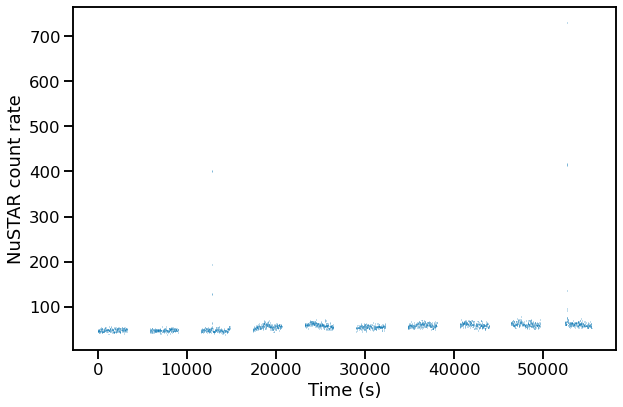

In [4]:
plt.ion()
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
# PI_max = 960   # 40.0 keV
PI_max = 1909   # 78.0 keV
events = extract_events(products_dir + 'nu' + OBSID + 'A01_cl_barycorr.evt', \
            products_dir + 'nu' + OBSID + 'B01_cl_barycorr.evt')

centroid_A = [535.28765,442.54501]
centroid_B = [529.3656,440.76094]
extraction_radius = 40.681706 # 90 arcsec


# plt.ion()

curve_A = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_bk.lc'))
curve_B = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_bk.lc'))
curve_total = sum_lc(curve_A, curve_B)
curve_10s = curve_total.rebin(dt_new=10)

t_start = np.min(curve_total.time)

plt.figure(figsize = (9,6))
plt.errorbar(curve_10s.time-t_start, curve_10s.countrate, xerr=curve_10s.dt/2., yerr=curve_10s.countrate_err, fmt='none', lw = 0.5)
plt.xlabel('Time (s)')
plt.ylabel('NuSTAR count rate')
plt.tight_layout()
plt.show()
plt.close()



# Persistent emission

In [5]:
bin_time = 1/2048
split_time = 256

curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius, gti = persistent_gti)
curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius, gti = persistent_gti)

averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')


/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
113it [00:39,  2.86it/s]
113it [00:32,  3.43it/s]
113it [00:32,  3.49it/s]


In [6]:
f_res = 0.1
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-5,5*np.max(averaged_cross_log.power*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent/' + 'CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-5,5*np.max(averaged_cross_log.power)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent/' + 'CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
plt.close()

# Model continuum

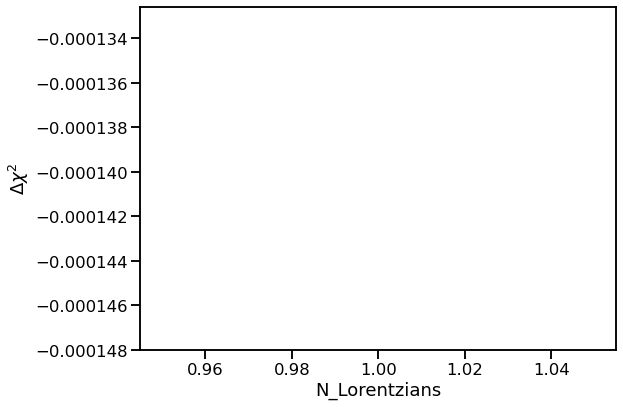

In [7]:
n_L, popt_list, pcov_list, chisq0, chisq = model_continuum_noise(averaged_cross, plot=True, plot_dir=plot_dir + 'persistent/', f_res=f_res, rebinned_cospec= averaged_cross_log, pl=True)

del_chisq = np.array(chisq) - chisq0

plt.figure(figsize=(9,6))
plt.plot(np.array(range(n_L)) + 1, -del_chisq)
plt.xlabel('N_Lorentzians')
plt.ylabel(r'$\Delta\chi^{2}$')
# plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()


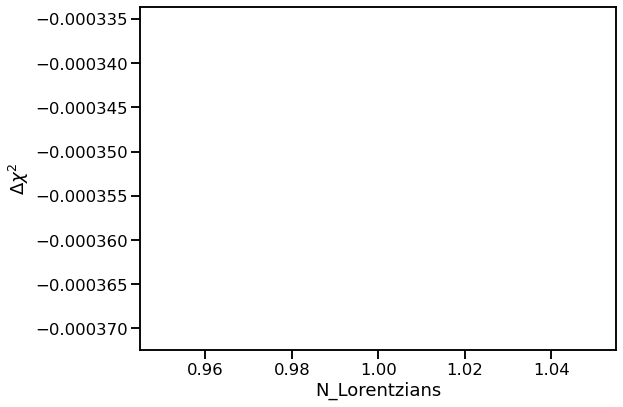

In [8]:
n_L, popt_list, pcov_list, chisq0, chisq = model_continuum_noise(averaged_cross, plot=True, plot_dir=plot_dir + 'persistent/', f_res=f_res, rebinned_cospec= averaged_cross_log, pl=False)

del_chisq = np.array(chisq) - chisq0

plt.figure(figsize=(9,6))
plt.plot(np.array(range(n_L)) + 1, -del_chisq)
plt.xlabel('N_Lorentzians')
plt.ylabel(r'$\Delta\chi^{2}$')
# plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()

### QPO search

In [12]:
# f_min = np.min(averaged_cross.freq)
# f_max = np.min([2000., (np.max(averaged_cross.freq))])
# freqs, chisq0, chisq, dof = QPO_scan(averaged_cross, f_min=f_min, f_max=f_max, f_bin = 500)

print(chisq0)

258069.7639530517


In [10]:
print(chisq0/dof)
plt.figure(figsize=(9,6))
plt.plot(freqs, (chisq - chisq0))
plt.xscale('log')
plt.ylabel(r'$\Delta\chi^{2}$')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.savefig(plot_dir + 'persistent/' + 'QPO_scan.pdf')
plt.close()

0.9844880670836959


In [11]:
peaks, _ = scipy.signal.find_peaks(-(chisq - chisq0), height = 10.0)
QPO_candidates = []
f_mask = (averaged_cross.freq > f_min) * (averaged_cross.freq < f_max) 
xdata = averaged_cross.freq[f_mask]
ydata = averaged_cross.power[f_mask]
sigma = averaged_cross.power_err[f_mask]

popt_arr, pcov_arr = fit_peaks(xdata, ydata, sigma, freqs[peaks])

sigma_arr = []

for i in range(len(popt_arr)):
    print(popt_arr[i])
    print(np.sqrt(np.diag(pcov_arr[i])))
    sigma_arr.append(np.sqrt(np.diag(pcov_arr[i])))
sigma_arr = np.array(sigma_arr)

for i in range(len(popt_arr)):
    print(popt_arr[i][2]/sigma_arr[i][2])




[ 1.00925599e+01  1.99660474e+01  1.47551227e-03  8.86229539e-05
 -1.30320597e+00]
[1.52187635e-01 1.70077180e+01 8.88720970e-04 7.87438493e-05
 1.97774949e-01]
1.6602649471199868


In [ ]:
plt.ion()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
plt.plot(averaged_cross_log.freq, Lorentzian_power(averaged_cross_log.freq, *(popt_arr[1])), color='red')
plt.xscale('log')
plt.ylim((1e-5,5*np.max(averaged_cross_log.power*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power x Frequency')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent/' + 'CPDS_' + str(int(split_time)) + 's_QPO_fit.pdf')
plt.close()



## Both Bursts

In [13]:
bin_time = 1/2048
split_time = 1

curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius, gti = burst_gti)
curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius, gti = burst_gti)

averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')

tmp_mask = (averaged_cross.freq < 590) * (averaged_cross.freq > 588)

rms = np.sqrt((np.sum(averaged_cross.power[tmp_mask])*averaged_cross.df))
rms_err = np.sqrt(np.sum(np.square(averaged_cross.power_err[tmp_mask])))*averaged_cross.df/(2*rms)
print(str(rms) + ' +/- ' + str(rms_err))
print(str(rms+ (2.6*rms_err)))

/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
213it [00:00, 267.71it/s]
213it [00:00, 239.28it/s]
213it [00:00, 259.25it/s]

0.0891378913353799 +/- 0.02764548539978505
0.16101615337482103


In [14]:
f_res = 0.01
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,5*np.max(averaged_cross_log.power*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst/' + 'CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,5*np.max(averaged_cross_log.power)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst/' + 'CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
plt.close()

### QPO search

In [31]:
f_min = np.min(averaged_cross.freq)
f_max = np.min([2000., (np.max(averaged_cross.freq))])
freqs, chisq0, chisq, dof = QPO_scan(averaged_cross, f_min=f_min, f_max=f_max, f_bin = 500)

  3%|▎         | 14/500 [00:00<00:03, 131.92it/s]

[ 6.34752181e-05 -2.97747291e+01]
927.3804563075287
0.9100887696835414


 40%|███▉      | 199/500 [00:02<00:02, 119.72it/s]/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: underflow encountered in power
/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: underflow encountered in multiply
 59%|█████▉    | 296/500 [00:03<00:03, 51.01it/s] 

No acceptable fit


 90%|█████████ | 450/500 [00:05<00:01, 47.55it/s] 

No acceptable fit


 92%|█████████▏| 460/500 [00:05<00:01, 31.57it/s]

No acceptable fit


 96%|█████████▌| 480/500 [00:06<00:00, 33.11it/s]

No acceptable fit


100%|██████████| 500/500 [00:06<00:00, 74.51it/s]


In [32]:
print(chisq0/dof)
plt.figure(figsize=(9,6))
plt.plot(freqs, (chisq - chisq0))
plt.xscale('log')
plt.ylabel(r'$\Delta\chi^{2}$')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.savefig(plot_dir + 'burst/' + 'QPO_scan.pdf')
plt.close()

0.9127760396727644


In [34]:
peaks, _ = scipy.signal.find_peaks(-(chisq - chisq0), height = 8.0)
QPO_candidates = []
f_mask = (averaged_cross.freq > f_min) * (averaged_cross.freq < f_max) 
xdata = averaged_cross.freq[f_mask]
ydata = averaged_cross.power[f_mask]
sigma = averaged_cross.power_err[f_mask]

popt_arr, pcov_arr = fit_peaks(xdata, ydata, sigma, freqs[peaks])

sigma_arr = []

for i in range(len(popt_arr)):
    print(popt_arr[i])
    print(np.sqrt(np.diag(pcov_arr[i])))
    sigma_arr.append(np.sqrt(np.diag(pcov_arr[i])))
sigma_arr = np.array(sigma_arr)

for i in range(len(popt_arr)):
    print(popt_arr[i][2]/sigma_arr[i][2])




[ 4.78488814e+02  7.74249578e+04  1.92991818e+00  3.10709959e-37
 -9.83456476e+00]
[1.18730810e-01 4.07500807e+09 1.01567233e+05 4.28732548e+00
 0.00000000e+00]
[ 8.92769174e+02  4.43950745e+01  6.42536523e-02  1.06865842e-26
 -6.71718684e+00]
[ 8.2706048  51.66735148  0.0528725   0.49361517  0.        ]
1.900138582113206e-05
1.2152564756060662


In [ ]:
plt.ion()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
plt.plot(averaged_cross_log.freq, Lorentzian_power(averaged_cross_log.freq, *(popt_arr[1])), color='red')
plt.xscale('log')
plt.ylim((1e-5,5*np.max(averaged_cross_log.power*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power x Frequency')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst/' + 'CPDS_' + str(int(split_time)) + 's_QPO_fit.pdf')
plt.close()



## Burst 1

In [37]:
bin_time = 1/2048
split_time = 1

curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius, gti = burst1_gti)
curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius, gti = burst1_gti)

averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')

tmp_mask = (averaged_cross.freq < 590) * (averaged_cross.freq > 588)

rms = np.sqrt((np.sum(averaged_cross.power[tmp_mask])*averaged_cross.df))
rms_err = np.sqrt(np.sum(np.square(averaged_cross.power_err[tmp_mask])))*averaged_cross.df/(2*rms)
print(str(rms) + ' +/- ' + str(rms_err))
print(str(rms+ (2.6*rms_err)))

115it [00:00, 251.46it/s]
115it [00:00, 264.21it/s]
115it [00:00, 266.42it/s]

0.12066925364657918 +/- 0.032147287839382484
0.20425220202897365


In [23]:
# f_res = 0.01
# averaged_cross_log = averaged_cross.rebin_log(f=f_res)
# averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,5*np.max(averaged_cross_log.power*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst/burst1/' + 'CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,5*np.max(averaged_cross_log.power)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst/burst1/' + 'CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
plt.close()

## Burst 2

In [38]:
bin_time = 1/2048
split_time = 1

curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius, gti = burst2_gti)
curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius, gti = burst2_gti)

averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')

tmp_mask = (averaged_cross.freq < 590) * (averaged_cross.freq > 588)

rms = np.sqrt((np.sum(averaged_cross.power[tmp_mask])*averaged_cross.df))
rms_err = np.sqrt(np.sum(np.square(averaged_cross.power_err[tmp_mask])))*averaged_cross.df/(2*rms)
print(str(rms) + ' +/- ' + str(rms_err))
print(str(rms+ (2.6*rms_err)))

98it [00:00, 260.36it/s]
98it [00:00, 278.61it/s]
98it [00:00, 281.06it/s]

0.043183257968433225 +/- 0.06532526949526594
0.2130289586561247


In [25]:
f_res = 0.01
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,5*np.max(averaged_cross_log.power*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst/burst2/' + 'CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,5*np.max(averaged_cross_log.power)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst/burst2/' + 'CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
plt.close()

# Pre-burst emission

In [35]:
bin_time = 1/2048
split_time = 256

PI_min = 35     # 3.0 keV
PI_max = 260     # 12.0 keV

curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius, gti = pre_burst1_gti)
curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius, gti = pre_burst1_gti)

averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')


/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
18it [00:05,  3.01it/s]
18it [00:04,  3.81it/s]
18it [00:04,  3.82it/s]


In [36]:
f_res = 0.1
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-5,5*np.max(averaged_cross_log.power*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent/preburst1/' + 'CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-5,5*np.max(averaged_cross_log.power)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent/preburst1/' + 'CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
plt.close()

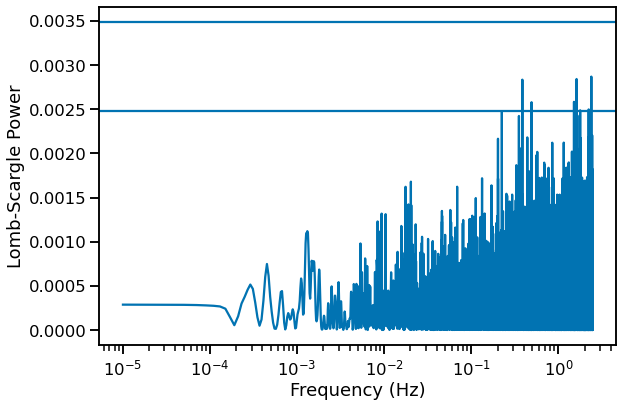

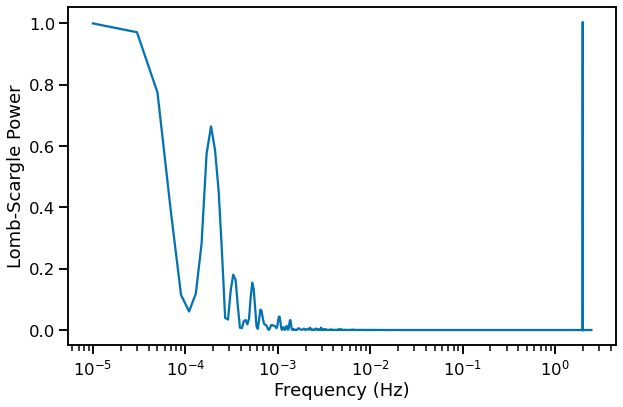

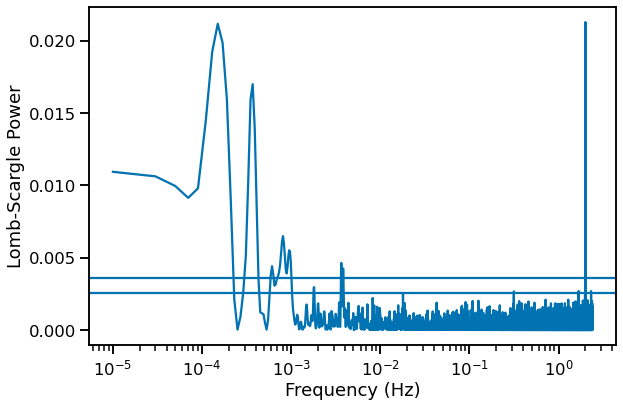

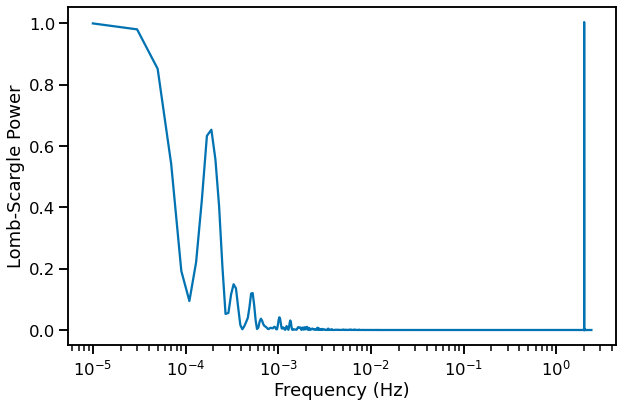

In [17]:
temp_mask = (curve_total.time < pre_burst1_gti[0][1]) * (curve_total.time > pre_burst1_gti[0][0])
## Calculate Lomb-Scargle
ls1 = LombScargle(curve_total.time[temp_mask]-t_start, curve_total.countrate[temp_mask], dy=curve_total.countrate_err[temp_mask])
frequency, power = ls1.autopower()
plt.figure(figsize=(9,6))
plt.plot(frequency, power, rasterized=True)
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Lomb-Scargle Power')
plt.axhline(ls1.false_alarm_level([1-0.68]))
plt.axhline(ls1.false_alarm_level([1-0.997]))
plt.tight_layout()
plt.savefig(plot_dir + 'persistent/preburst1/lomb_scargle.pdf')

## Calculate Lomb-Scargle on window
frequency, power = LombScargle(curve_total.time[temp_mask]-t_start, np.ones(np.shape(curve_total.countrate[temp_mask])), fit_mean=False, center_data=False).autopower()
plt.figure(figsize=(9,6))
plt.plot(frequency, power, rasterized=True)
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Lomb-Scargle Power')
plt.tight_layout()
plt.savefig(plot_dir + 'persistent/preburst1/lomb_scargle_window.pdf')




temp_mask = (curve_total.time < pre_burst2_gti[0][1]) * (curve_total.time > pre_burst2_gti[0][0])
## Calculate Lomb-Scargle
ls2 = LombScargle(curve_total.time[temp_mask]-t_start, curve_total.countrate[temp_mask], dy=curve_total.countrate_err[temp_mask])
frequency, power = ls2.autopower()
plt.figure(figsize=(9,6))
plt.plot(frequency, power, rasterized=True)
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Lomb-Scargle Power')
plt.axhline(ls2.false_alarm_level([1-0.68]))
plt.axhline(ls2.false_alarm_level([1-0.997]))
plt.tight_layout()
plt.savefig(plot_dir + 'persistent/preburst2/lomb_scargle.pdf')

## Calculate Lomb-Scargle on window
frequency, power = LombScargle(curve_total.time[temp_mask]-t_start, np.ones(np.shape(curve_total.countrate[temp_mask])), fit_mean=False, center_data=False).autopower()
plt.figure(figsize=(9,6))
plt.plot(frequency, power, rasterized=True)
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Lomb-Scargle Power')
plt.tight_layout()
plt.savefig(plot_dir + 'persistent/preburst2/lomb_scargle_window.pdf')





# Model continuum

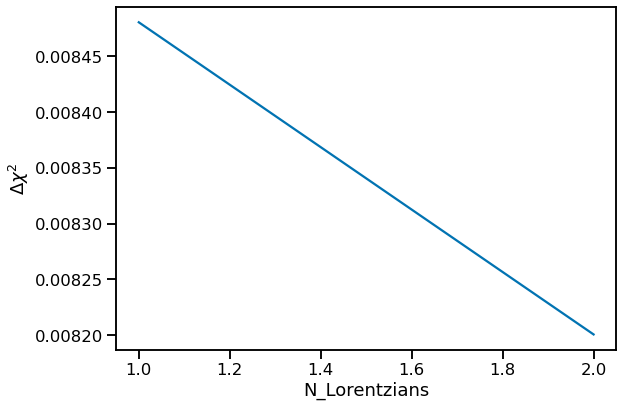

In [47]:
n_L, popt_list, pcov_list, chisq0, chisq = model_continuum_noise(averaged_cross, plot=True, plot_dir=plot_dir + 'persistent/preburst1', f_res=f_res, rebinned_cospec= averaged_cross_log, pl=True)

del_chisq = np.array(chisq) - chisq0

plt.figure(figsize=(9,6))
plt.plot(np.array(range(n_L)) + 1, -del_chisq)
plt.xlabel('N_Lorentzians')
plt.ylabel(r'$\Delta\chi^{2}$')
# plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()


### QPO search

In [37]:
f_min = np.min(averaged_cross.freq)
f_max = np.min([2000., (np.max(averaged_cross.freq))])
freqs, chisq0, chisq, dof = QPO_scan(averaged_cross, f_min=f_min, f_max=f_max, f_bin = 500)

  0%|          | 0/500 [00:00<?, ?it/s]

[ 1.89823592e-16 -6.71479865e+00]
258484.7380231236
0.9860598309413082


100%|██████████| 500/500 [45:07<00:00,  5.41s/it]


In [38]:
print(chisq0/dof)
plt.figure(figsize=(9,6))
plt.plot(freqs, (chisq - chisq0))
plt.xscale('log')
plt.ylabel(r'$\Delta\chi^{2}$')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.savefig(plot_dir + 'persistent/preburst1/' + 'QPO_scan.pdf')
plt.close()

0.9860711158449186


In [39]:
peaks, _ = scipy.signal.find_peaks(-(chisq - chisq0), height = 10.0)
QPO_candidates = []
f_mask = (averaged_cross.freq > f_min) * (averaged_cross.freq < f_max) 
xdata = averaged_cross.freq[f_mask]
ydata = averaged_cross.power[f_mask]
sigma = averaged_cross.power_err[f_mask]

popt_arr, pcov_arr = fit_peaks(xdata, ydata, sigma, freqs[peaks])

sigma_arr = []

for i in range(len(popt_arr)):
    print(popt_arr[i])
    print(np.sqrt(np.diag(pcov_arr[i])))
    sigma_arr.append(np.sqrt(np.diag(pcov_arr[i])))
sigma_arr = np.array(sigma_arr)

for i in range(len(popt_arr)):
    print(popt_arr[i][2]/sigma_arr[i][2])




[ 1.62513644e+00  5.52484793e+00  2.03777637e-03  4.90923165e-16
 -7.62648189e-01]
[1.48635806e-01 7.99602087e+00 2.09871987e-03 2.92157889e-04
 2.31755935e-17]
[ 1.44374834e+01  1.13000702e+01  3.52744604e-03  4.17948653e-15
 -7.15384435e-01]
[7.77218836e-01 1.94997806e+01 4.31147745e-03 3.32768458e-04
 1.96723322e-11]
[ 2.21312021e+01  1.40411264e+01  3.75852941e-03  2.53355142e-15
 -7.56952365e-01]
[9.99478458e-01 2.52167419e+01 4.77565819e-03 2.92628943e-04
 1.92326669e-15]
[ 3.96091070e+02  2.44092961e+01  1.67832590e-33  1.58680096e-15
 -6.27343993e+00]
[0.00000000e+00 0.00000000e+00 1.57653743e-33 1.45752474e-15
 1.12157418e-29]
0.9709615837832312
0.8181524965462198
0.787018094193311
1.0645645758867743


In [ ]:
plt.ion()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
plt.plot(averaged_cross_log.freq, Lorentzian_power(averaged_cross_log.freq, *(popt_arr[1])), color='red')
plt.xscale('log')
plt.ylim((1e-5,5*np.max(averaged_cross_log.power*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power x Frequency')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent/preburst1/' + 'CPDS_' + str(int(split_time)) + 's_QPO_fit.pdf')
plt.close()



# Pre-burst emission

In [40]:
bin_time = 1/2048
split_time = 256

PI_min = 35     # 3.0 keV
PI_max = 260     # 12.0 keV

curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius, gti = pre_burst2_gti)
curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius, gti = pre_burst2_gti)

averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')


/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
16it [00:05,  3.05it/s]
16it [00:04,  3.49it/s]
16it [00:04,  3.38it/s]


In [41]:
f_res = 0.1
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-5,5*np.max(averaged_cross_log.power*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent/preburst2/' + 'CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, color='black', lw=0.5, fmt='none')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-5,5*np.max(averaged_cross_log.power)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent/preburst2/' + 'CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
plt.close()

# Model continuum

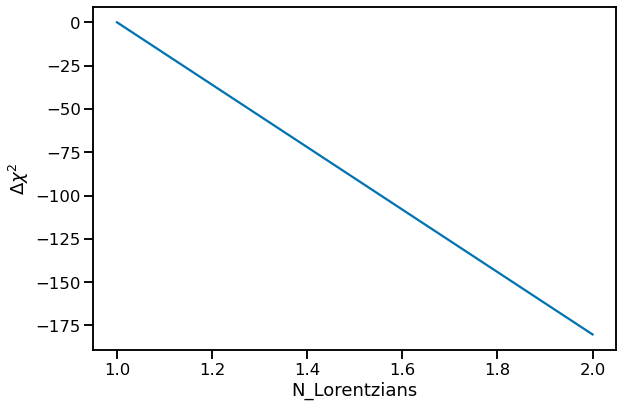

In [50]:
n_L, popt_list, pcov_list, chisq0, chisq = model_continuum_noise(averaged_cross, plot=True, plot_dir=plot_dir + 'persistent/preburst2/', f_res=f_res, rebinned_cospec= averaged_cross_log, pl=True)

del_chisq = np.array(chisq) - chisq0

plt.figure(figsize=(9,6))
plt.plot(np.array(range(n_L)) + 1, -del_chisq)
plt.xlabel('N_Lorentzians')
plt.ylabel(r'$\Delta\chi^{2}$')
# plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()


### QPO search

In [42]:
f_min = np.min(averaged_cross.freq)
f_max = np.min([2000., (np.max(averaged_cross.freq))])
freqs, chisq0, chisq, dof = QPO_scan(averaged_cross, f_min=f_min, f_max=f_max, f_bin = 500)

  0%|          | 0/500 [00:00<?, ?it/s]

[ 7.66475982e-04 -8.85610742e-01]
258635.61320319245
0.9866353850559911


100%|██████████| 500/500 [06:18<00:00,  1.32it/s]


In [43]:
print(chisq0/dof)
plt.figure(figsize=(9,6))
plt.plot(freqs, (chisq - chisq0))
plt.xscale('log')
plt.ylabel(r'$\Delta\chi^{2}$')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.savefig(plot_dir + 'persistent/preburst2/' + 'QPO_scan.pdf')
plt.close()

0.9866466765464966


In [44]:
peaks, _ = scipy.signal.find_peaks(-(chisq - chisq0), height = 10.0)
QPO_candidates = []
f_mask = (averaged_cross.freq > f_min) * (averaged_cross.freq < f_max) 
xdata = averaged_cross.freq[f_mask]
ydata = averaged_cross.power[f_mask]
sigma = averaged_cross.power_err[f_mask]

popt_arr, pcov_arr = fit_peaks(xdata, ydata, sigma, freqs[peaks])

sigma_arr = []

for i in range(len(popt_arr)):
    print(popt_arr[i])
    print(np.sqrt(np.diag(pcov_arr[i])))
    sigma_arr.append(np.sqrt(np.diag(pcov_arr[i])))
sigma_arr = np.array(sigma_arr)

for i in range(len(popt_arr)):
    print(popt_arr[i][2]/sigma_arr[i][2])




[ 1.93929630e-02  5.25584745e+01  6.18241160e-05  6.78916501e-04
 -8.67053189e-01]
[1.15911590e-01 2.49783362e+04 2.90064016e-02 4.88005960e-04
 1.82814576e-01]
[ 9.53325732e+01  5.15269367e+02  2.24027022e-03  7.56428814e-04
 -8.88876351e-01]
[5.55862319e-02 4.37889576e+02 1.34629574e-03 4.78010942e-04
 1.57238394e-01]
[ 1.37423817e+02  1.22844455e+01  3.93207712e-03  7.52806938e-04
 -8.90067156e-01]
[1.48902169e+01 4.63714492e+01 1.05122193e-02 4.79484136e-04
 1.58388397e-01]
[ 2.88667373e+02  1.00000013e+00  1.46142699e-09  7.66865117e-04
 -8.85478836e-01]
[1.85790615e-13 1.11922969e-10 3.88105034e-02 4.88988172e-04
 1.58899648e-01]
[ 3.10888042e+02  7.51028152e+01  1.43384874e-02  7.40936837e-04
 -8.94049366e-01]
[9.19118942e-01 4.71752513e+01 6.36977913e-03 4.76182841e-04
 1.59498249e-01]
0.002131395575897871
1.6640253338365796
0.3740482393703906
3.7655450558482836e-08
2.2510179929777387


In [ ]:
plt.ion()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
plt.plot(averaged_cross_log.freq, Lorentzian_power(averaged_cross_log.freq, *(popt_arr[1])), color='red')
plt.xscale('log')
plt.ylim((1e-5,5*np.max(averaged_cross_log.power*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power x Frequency')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent/preburst2/' + 'CPDS_' + str(int(split_time)) + 's_QPO_fit.pdf')
plt.close()

